# Kerasを使った畳み込みネットワーク(CNN)学習

## MNISTデータセットとは？
MNISTとは、0から9までの70,000個の手書き数字の画像から構成された、画像分類問題において非常に人気の高いデータセット。

MNISTデータセットにおける0～9の手書きの数字には正解ラベルがついており、コンピュータービジョンを使って、画像データからこの正解ラベルを導き出すことを目的とする。

MNISTは、機械学習の「Hello World」と呼ばれるくらい入門で使われるデータセットであり、最新のアルゴリズムや技術などを評価するためのベンチマークとしても利用されている。

## ニューラルネットと畳み込みニューラルネットワーク
ニューラルネットワークとは、一番単純な説明としては「人間の脳の構造を模したコンピューターシステム」である。

一言でニューラルネットーワークと言っても、処理をする目的などに応じて様々な種類が存在する。
CNN（畳み込みニューラルネットワーク）はその一つに属するニューラルネットワークとなる。

CNNは特に「生物の脳の視覚野の構造を模倣したコンピューターシステム」であり、画像認識及び分類において極めて良好に機能するニューラルネットワークとなる。

## Kerasとは？
KerasはPythonで描かれたディープラーニングラリブラリで、TensorFlowやTheanoの上で実行可能な高水準のニューラルネットワークAPI。

非常に簡単かつ高速にニューラルネットワークを構築することが可能で、GoogleやMicrosoftなどの大手でも利用されているライブラリである。

また機械学習系のライブラリでは非常に稀なことに、日本語で公式ドキュメントが用意されている。

In [10]:
# Kerasの必要なコンポーネントをインポート
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils

# Scikit-learn(Sklearn)のインポート
import sklearn

# データを高速かつ効率的に使えるPandasをインポート
import pandas as pd
# 数値計算を効率的に行うNumpyをインポート
import numpy as np

# グラフが簡単に描写できるMatplotlibをインポート
import matplotlib
import matplotlib.pyplot as plt

In [11]:
# Scikit-learnでMNISTオリジナルデータを読み込み
mnist = sklearn.datasets.fetch_mldata('MNIST original', data_home='.') # カレントディレクトリにmldataフォルダを作り .matデータをダウンロード

In [12]:
# データセットを説明変数（特徴量）と目的変数（解答）に切り分ける
X, y = mnist['data'], mnist['target']

print(X.shape, y.shape)

(70000, 784) (70000,)


### 特徴量のデータと正解ラベルの確認

mnistのデータにおける特徴量は784個の数値データで構成されているが、これを28×28のマトリックスに変換することで手書きの数字になっていることが確認できる。また、それに関連付けられている正解ラベルが、手書きの数字と同一であるか、以下のテストで確認する。

以下のテストコードは、適当に選んだ53238番目のデータを使って、手書きの数字データと正解ラベルを確認している。

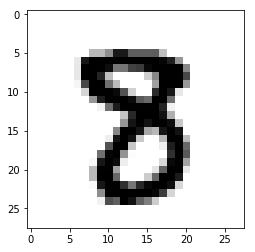

8.0


In [13]:
# Xの53238番目のデータをtest_numberへ切り出す
test_number = X[53238]
 
# reshape関数を使って784の数列を28x28の画像データへ変換する
test_number_image = test_number.reshape(28,28)

# imshowを使って表示test_number_image（Numpy配列）を画像で表示
%matplotlib inline 
 
plt.imshow(test_number_image, cmap = matplotlib.cm.binary,
           interpolation='nearest')
plt.show()

# 正解ラベルの確認
# 53238番目のYの値を出力
print(y[53238])

### ニューラルネットワークのためのデータ前処理

次のステップでは、Kerasへインプットさせるデータの事前処理を行う。機械学習ではこのデータの事前処理が非常に重要となるが、今回は特に難しいことは行わず、必要最低限の前処理を行う。

まずは訓練データとテストデータへ切り分けを行う。訓練データはCNNへ訓練をさせる（学ばさせる）データである。訓練データを使って構築したモデルに、今度は訓練で全く使ったことのない（モデルに学習をさせていない）テストデータを使って構築したモデルの良し悪しを判断することになる。

mnistには70000個の画像データがあるため、訓練データとして60000個、テストデータとして10000個に切り分けることにした。

In [25]:
# 訓練データとテストデータを切り分ける
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_test_backup = y_test
 
# 両方のサイズを確認
print(X_train.shape, X_test.shape)

(60000, 784) (10000, 784)


In [31]:
# 特徴量を28x28x1のサイズへリシェイプし、Kerasで扱えるようにfloat32型に変換
X_train_norm = X_train.reshape(X_train_norm.shape[0], 28, 28, 1).astype('float32')
X_test_norm = X_test.reshape(X_test_norm.shape[0], 28, 28, 1).astype('float32')

# 正規化
## アルゴリズムの計算処理をスムーズに行うため、数値を0～1の値になるように変換
### なお、今回の場合は最小値が0で最大値が255であることがわかっているので、単純に255で割っているが、
### 最大値、最小値がわからない場合は、sklearn.preprocessing.MinMaxScalerを使うと良い
X_train_norm /= 255
X_test_norm /= 255

In [32]:
# 目的変数をバイナリクラスに変換
## この処理は、yの値を10個の数値の配列に変換し、必要な箇所の数値を「1」、それ以外は全て「0」というデータに変換する
### 例) y = 0 = [1,0,0,0,0,0,0,0,0,0], y = 5 = [0,0,0,0,0,1,0,0,0,0]
y_train_bin = np_utils.to_categorical(y_train, 10)
y_test_bin = np_utils.to_categorical(y_test, 10)
 
# y_test_binの1を表示
y_test_bin[1]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [33]:
# モデルの宣言
model = Sequential()

# ニューラルネットワークの層の構築
## modelへレイヤーを追加
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# 学習プロセスの設定
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# モデルの訓練（エポック(学習の回数) = 10）
## ！このプロセスには10～15分かかる
## ！GeForce GTX1070のGPUを使用した場合、1～2分
model.fit(X_train_norm, y_train_bin, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 6s 103us/step - loss: 0.5306 - acc: 0.8502
Epoch 2/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.2503 - acc: 0.9259: 1s - los
Epoch 3/10
60000/60000 [==============================] - 6s 99us/step - loss: 0.1921 - acc: 0.9431: 0s - loss: 0.1951
Epoch 4/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.1531 - acc: 0.9543
Epoch 5/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.1300 - acc: 0.9617
Epoch 6/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.1099 - acc: 0.9675
Epoch 7/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.0981 - acc: 0.9715
Epoch 8/10
60000/60000 [==============================] - 6s 96us/step - loss: 0.0871 - acc: 0.9741: 1s - loss
Epoch 9/10
60000/60000 [==============================] - 6s 96us/step - loss: 0.0774 - acc: 0.9769
Epoch 10/10
60000/60000 [==============================] - 

In [37]:
# X_testを使って予測を行う
pred = model.predict_classes(X_test_norm)
x = list(pred)
y = list(y_test)
results = pd.DataFrame({'Actual': y, 'Predictions': x})
results.to_csv("01.Keras_CNN.csv", index=False) # csvに保存しておく
results[0:10]

,Actual,Predictions
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0


In [42]:
import json

# 学習したModelとParameterを保存しておく
with open("01.Keras_CNN.Model.json", 'w') as f:
    f.write(json.dumps(json.loads(model.to_json()), ensure_ascii=False, indent=2))

model.save_weights("01.Keras_CNN.Weights.hdf5")